Imports

In [41]:
import os
import requests
from time import sleep
from dotenv import load_dotenv
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import requests
from io import BytesIO

Load environmental variables

In [42]:
load_dotenv()
FOUNDRY_ENDPOINT = os.getenv("FOUNDRY_ENDPOINT")
FOUNDRY_API_KEY = os.getenv("FOUNDRY_API_KEY")
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_MODEL = os.getenv("AZURE_OPENAI_MODEL")

Send a document for analysis

In [43]:
def analyze_document(file_url, analyzer_id="prebuilt-documentAnalyzer"):
    url = f"{FOUNDRY_ENDPOINT}/contentunderstanding/analyzers/{analyzer_id}:analyze?api-version=2025-05-01-preview"
    headers = {
        "Ocp-Apim-Subscription-Key": FOUNDRY_API_KEY,
        "Content-Type": "application/json"
    }
    data = {
        "url": file_url
    }
    response = requests.post(url, headers=headers, json=data)
    response.raise_for_status()
    
    # Get the operation URL from headers
    operation_location = response.headers.get('Operation-Location')
    if not operation_location:
        raise Exception("Operation-Location header not found in response")

    return operation_location

test_file_url = "https://ai.azure.com/extensions/visdoc/ocr_checklist.jpg"
#test_file_url = "https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/media/overview/simple-form.png"

doc_id = analyze_document(test_file_url)
print(doc_id)

https://foundry-mikkolabs.services.ai.azure.com/contentunderstanding/analyzerResults/51e5982a-4e82-4f17-a68d-f92191b55287?api-version=2025-05-01-preview


Get the results. (Sleep added in case you're using Run All.)

In [44]:
sleep(15) # Just in case you're running Run All!

In [45]:
result_response = requests.get(
    doc_id,
    headers={"Ocp-Apim-Subscription-Key": FOUNDRY_API_KEY}
)

result_response.raise_for_status()
result = result_response.json()

print(f"Status: {result.get('status')}")

Status: Succeeded


If the status is Running, wait a few seconds and try again.

If the status is Succeeded, you can view the analysis in different formats.

Markdown:

In [46]:
print(result['result']['contents'][0]['markdown'])

# Documents to Store and Share

This template can be used as a checklist for documents you should store securely and share with
others. Always keep original documents. Make copies of the most important ones (marked with
an *) and have them certified. Store these separately, such as in a safe deposit box. Learn how to
share files and password-protect them with OneDrive.


<table>
<tr>
<th>Document</th>
<th>Share with</th>
</tr>
<tr>
<td>☐ Adoption or guardianship papers*</td>
<td>Personal attorney, executor</td>
</tr>
<tr>
<td>☒ Annuity contracts</td>
<td>Financial advisor</td>
</tr>
<tr>
<td>☒ Bank account documents</td>
<td>Add name(s) Ardak Sultan</td>
</tr>
<tr>
<td>☐ Bank loan agreements</td>
<td>Add name(s)</td>
</tr>
<tr>
<td>☒ Bank statements</td>
<td>Add name(s) Parvesh Giri</td>
</tr>
<tr>
<td>☐ Birth certificates*</td>
<td>Add name(s)</td>
</tr>
<tr>
<td>☒ Business licence*</td>
<td>Add name(s) Jerome Rivard</td>
</tr>
<tr>
<td>☒ 'Cancelled checks</td>
<td>Add name(s)</td>
</

JSON with locations:

In [47]:
#found_words = result['result']['contents'][0]['pages'][0]['words']
#for word in found_words: print(word)

found_lines = result['result']['contents'][0]['pages'][0]['lines']
for line in found_lines: print(line)

{'content': 'Documents to Store and Share', 'source': 'D(1,212,211,1748,177,1749,278,213,312)', 'span': {'offset': 2, 'length': 28}}
{'content': 'This template can be used as a checklist for documents you should store securely and share with', 'source': 'D(1,201,446,2071,409,2073,458,202,497)', 'span': {'offset': 32, 'length': 95}}
{'content': 'others. Always keep original documents. Make copies of the most important ones (marked with', 'source': 'D(1,199,504,2053,467,2054,517,200,555)', 'span': {'offset': 128, 'length': 91}}
{'content': 'an *) and have them certified. Store these separately, such as in a safe deposit box. Learn how to', 'source': 'D(1,197,562,2074,527,2075,575,198,613)', 'span': {'offset': 220, 'length': 98}}
{'content': 'share files and password-protect them with OneDrive.', 'source': 'D(1,194,622,1247,600,1248,647,195,670)', 'span': {'offset': 319, 'length': 52}}
{'content': 'Document', 'source': 'D(1,611,763,854,762,855,803,611,805)', 'span': {'offset': 391, 'lengt

In [48]:
response = requests.get(test_file_url)
image_orig = Image.open(BytesIO(response.content)).convert("RGB")

In [49]:
image = image_orig.copy()
draw = ImageDraw.Draw(image)
font = ImageFont.truetype("arial.ttf", 48)

# overlay the recognized text boxes on the image
for line in found_lines:
    box = line['source']
    # extract the coordinates from the source string
    coords = box[4:-1].split(',')
    coords = [int(c) for c in coords]
    
    # draw a rectangle around the text
    draw.polygon(coords, outline="red", width=2)

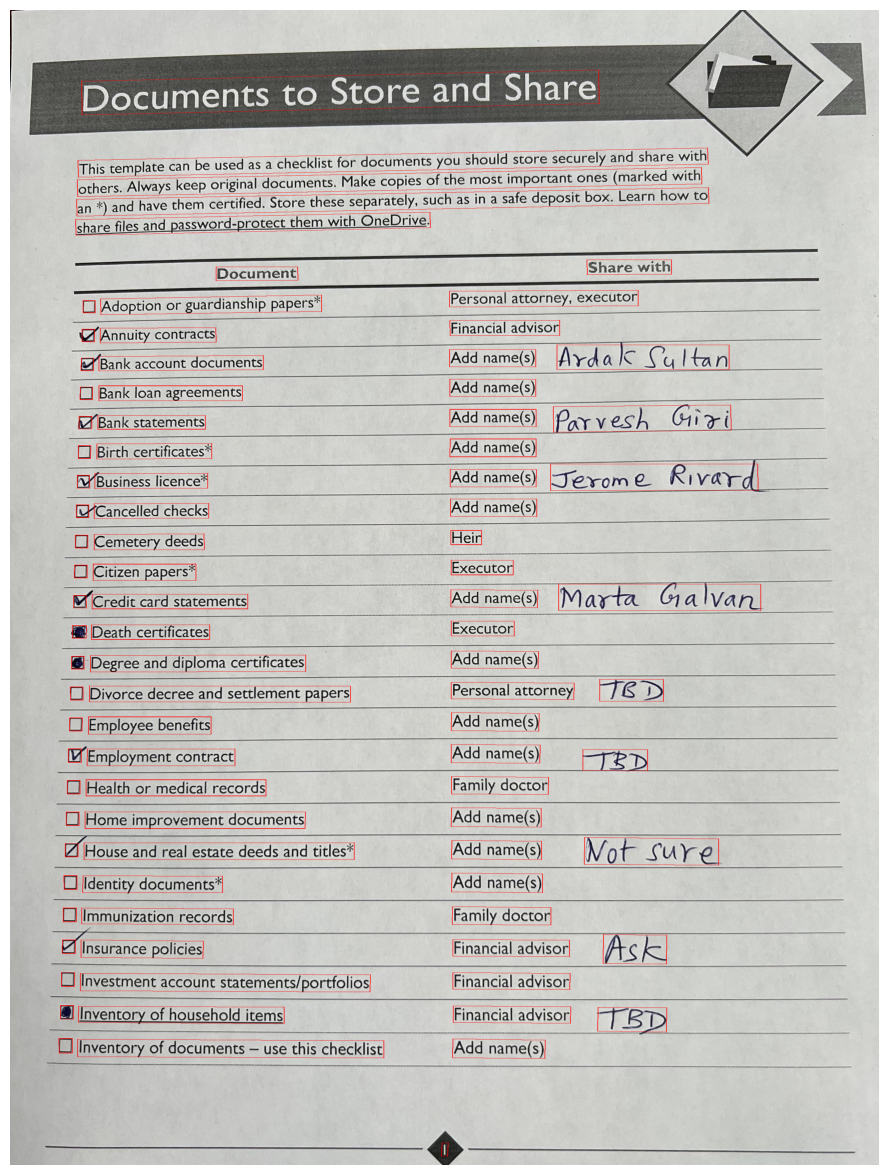

In [50]:
# Display the image with overlaid boxes and text
plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.axis('off')
plt.show()

# Add translations using Azure OpenAI

Let's translate the recognized text to Swedish while preserving proper names and maintaining context between lines.

In [51]:
# Set up Azure OpenAI client
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from openai import AzureOpenAI

# Get token provider for Azure OpenAI
token_provider = get_bearer_token_provider(
    DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default"
)

# Initialize Azure OpenAI client
client = AzureOpenAI(
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-04-01-preview",
    azure_ad_token_provider=token_provider
)

In [52]:
# Translate text while preserving proper names
def translate_text_with_context(texts):
    # Join texts with markers to maintain context but separate lines
    combined_text = " ||| ".join(texts)
    
    messages = [
        {"role": "system", "content": "You are a translator specializing in Swedish translations. Preserve all proper names exactly as they appear. Maintain formal language style."},
        {"role": "user", "content": f"Translate the following text to Swedish. Each text segment is separated by |||: {combined_text}"}
    ]
    
    response = client.chat.completions.create(
        model=AZURE_OPENAI_MODEL,
        messages=messages,
        temperature=0.1  # Lower temperature for more consistent translations
    )
    
    # Split the response back into individual translations
    translations = response.choices[0].message.content.split("|||")
    return [t.strip() for t in translations]

# Get original texts from the found lines
original_texts = [line['content'] for line in found_lines]
translated_texts = translate_text_with_context(original_texts)

# Print original and translations for verification
for orig, trans in zip(original_texts, translated_texts):
    print(f"Original: {orig}")
    print(f"Swedish:  {trans}")
    print()

Original: Documents to Store and Share
Swedish:  Dokument att lagra och dela

Original: This template can be used as a checklist for documents you should store securely and share with
Swedish:  Denna mall kan användas som en checklista för dokument som du bör lagra säkert och dela med

Original: others. Always keep original documents. Make copies of the most important ones (marked with
Swedish:  andra. Behåll alltid originaldokumenten. Ta kopior av de viktigaste dokumenten (markerade med

Original: an *) and have them certified. Store these separately, such as in a safe deposit box. Learn how to
Swedish:  en *) och låt dem bestyrkas. Förvara dessa separat, till exempel i ett bankfack. Lär dig hur du

Original: share files and password-protect them with OneDrive.
Swedish:  delar filer och lösenordsskyddar dem med OneDrive.

Original: Document
Swedish:  Dokument

Original: Share with
Swedish:  Dela med

Original: ☐
Swedish:  ☐

Original: Adoption or guardianship papers*
Swedish:  Adoptio

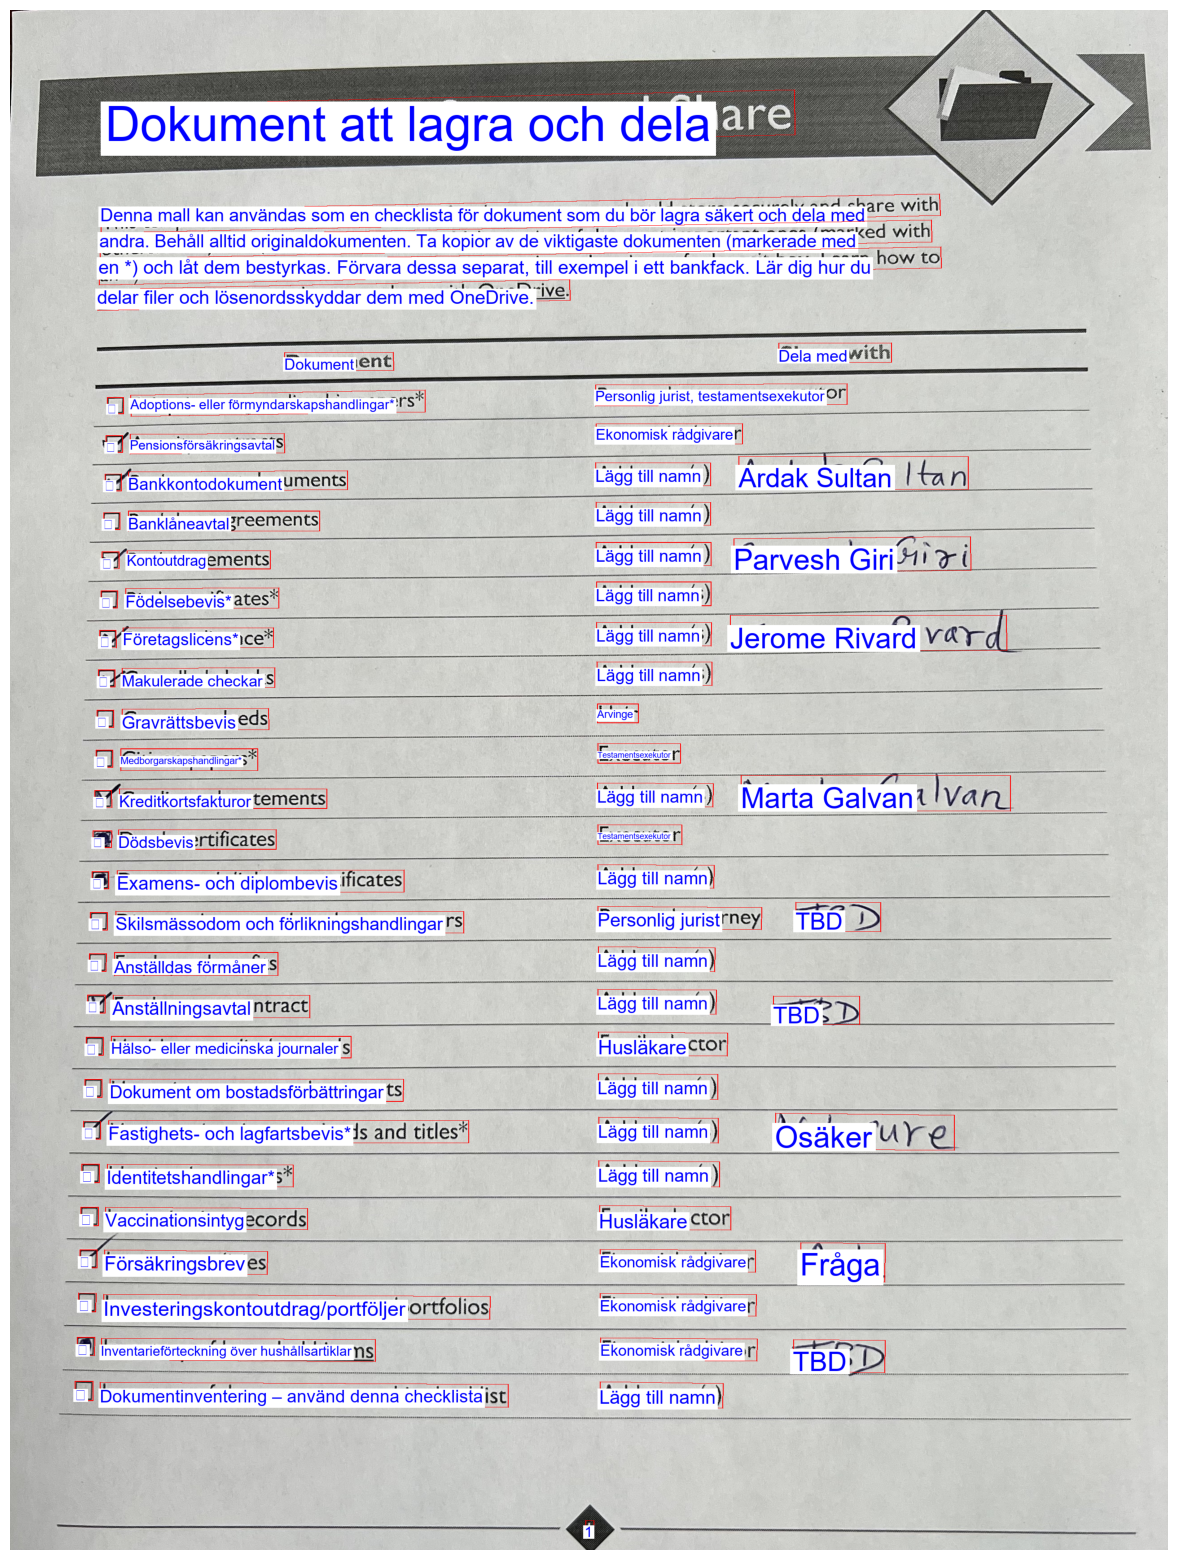

In [53]:
# Create a new image with translated text
image_with_translations = image_orig.copy()
draw = ImageDraw.Draw(image_with_translations)

# overlay the translated text boxes
for line, translation in zip(found_lines, translated_texts):
    box = line['source']
    coords = box[4:-1].split(',')
    coords = [int(c) for c in coords]
    
    # Calculate bounding box dimensions
    xs = coords[0::2]  # all x coordinates
    ys = coords[1::2]  # all y coordinates
    bbox_x1, bbox_y1 = min(xs), min(ys)
    bbox_x2, bbox_y2 = max(xs), max(ys)
    bbox_height = bbox_y2 - bbox_y1
    bbox_width = bbox_x2 - bbox_x1
    
    # Start with a reasonable font size based on box height
    font_size = int(bbox_height * 0.8)  # Start with 80% of box height
    font = ImageFont.truetype("arial.ttf", font_size)
    
    # Adjust font size until text fits width (with some margin)
    text_bbox = draw.textbbox((0, 0), translation, font=font)
    text_width = text_bbox[2] - text_bbox[0]
    while text_width > bbox_width * 0.95 and font_size > 12:  # Keep text readable
        font_size -= 2
        font = ImageFont.truetype("arial.ttf", font_size)
        text_bbox = draw.textbbox((0, 0), translation, font=font)
        text_width = text_bbox[2] - text_bbox[0]
    
    # Calculate text height for vertical centering
    text_height = text_bbox[3] - text_bbox[1]
    
    # draw a rectangle around the text area
    draw.polygon(coords, outline="red", width=2)
    
    # Position text centered in the box
    text_x = bbox_x1
    text_y = bbox_y1 + (bbox_height - text_height) / 2
    
    # Draw white background for text
    padding = max(2, int(font_size * 0.1))  # Proportional padding
    text_bbox = draw.textbbox((text_x, text_y), translation, font=font)
    draw.rectangle(
        [
            text_bbox[0] - padding,
            text_bbox[1] - padding,
            text_bbox[2] + padding,
            text_bbox[3] + padding
        ],
        fill="white",
        outline=None
    )
    
    # Draw the translated text
    draw.text((text_x, text_y), translation, fill="blue", font=font)

# Display the image with translations
plt.figure(figsize=(20, 20))
plt.imshow(image_with_translations)
plt.axis('off')
plt.show()